In [1]:
import jax.numpy as jnp
import jax
import orbax.checkpoint
import matplotlib.pyplot as plt

from doobs_score_matching.src.training import train_utils
from doobs_score_matching.src.models import score_mlp
from doobs_score_matching.src.sdes import sde_kunita, sde_utils, time

def load_checkpoint(checkpoint_path):
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    restored = orbax_checkpointer.restore(checkpoint_path)
    model = score_mlp.ScoreMLP(**restored["network"])
    params = restored["params"]
    batch_stats = restored["batch_stats"]
    trained_score = train_utils.trained_score(model, params, batch_stats)
    return trained_score


In [2]:
checkpoint_path = "../../checkpoints/kunita/fixed_x0_lms_5"

trained_score = load_checkpoint(checkpoint_path)

In [3]:
key = jax.random.PRNGKey(0)
ts = time.grid(0, 1.0, 100)

def sample_circle(num_landmarks: int, radius=1.0, centre=jnp.asarray([0, 0])) -> jnp.ndarray:
    theta = jnp.linspace(0, 2 * jnp.pi, num_landmarks, endpoint=False)
    x = jnp.cos(theta)
    y = jnp.sin(theta)
    return (radius * jnp.stack([x, y], axis=1) + centre).flatten()

y = sample_circle(5, radius=1.3)
target = sample_circle(5)
target = target.reshape(-1, 2)
drift, diffusion = sde_kunita.vector_fields()
bm_shape = (sde_kunita.GRID_SIZE**2 * 2,)

backward_trajs = sde_utils.conditioned(key, ts, y, trained_score, drift, diffusion, bm_shape)
forward_traj = sde_utils.solution(key, ts, y, drift, diffusion, bm_shape)

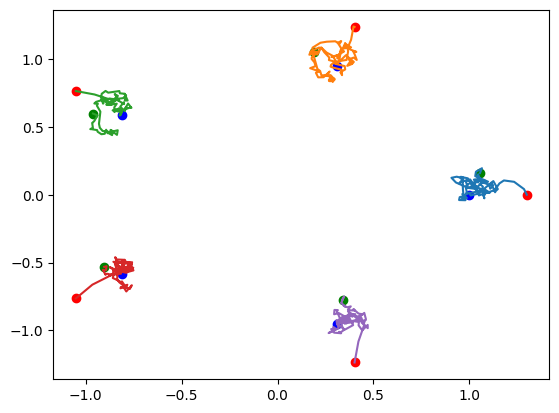

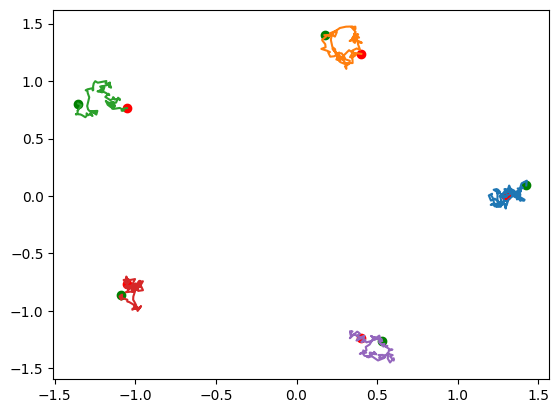

In [4]:
backward_traj = backward_trajs.reshape(-1, 5, 2)

for landmark in range(backward_traj.shape[1]):
    plt.plot(backward_traj[:, landmark, 0], backward_traj[:, landmark, 1])
    plt.scatter(backward_traj[0, landmark, 0], backward_traj[0, landmark, 1], c='red')
    plt.scatter(backward_traj[-1, landmark, 0], backward_traj[-1, landmark, 1], c='green')
    plt.scatter(target[landmark, 0], target[landmark, 1], c='blue')
plt.show()

forward_traj = forward_traj.reshape(-1, 5, 2)

for landmark in range(forward_traj.shape[1]):
    plt.plot(forward_traj[:, landmark, 0], forward_traj[:, landmark, 1])
    plt.scatter(forward_traj[0, landmark, 0], forward_traj[0, landmark, 1], c='red')
    plt.scatter(forward_traj[-1, landmark, 0], forward_traj[-1, landmark, 1], c='green')
plt.show()

In [15]:
print(forward_traj.shape)

(100, 4)
